# Finding the Key Using TRACES Sampled from Real Machines CPA
<div id=part2_cpa></div>

In [9]:
import csv,os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

For this part we use real traces which were taken from FPGA which performed encryption using AES
The database for all samples at the time of the last round can be found in the file `"_DATA1_keyset_9_attack.csv"`

In [10]:
KEYSET_FILE_PATH  = "./Resources/_DATA1_keyset_9_attack.csv"
CPA_HW_OUT_PATH = "./Resources/CPA_HW_Ex_Sample.dat"
CPA_Plot_PATH = "./Resources/CPA_AllKeyByte_N"
CPA_BOOK_RES_PATH = "./Resources/CPA_BOOK_RES.dat"
COR_TABLE_PATH = "./Resources/correlation_table.dat"
CPA_Book_Result_PATH = "./Resources/CPA_Book_Result.dat"

In [11]:
wstart = 10
wstop = 1999
wlen = wstop-wstart
InvSbox = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

## Section 2

Perform a CPA in which you compare the model (HW) and the measurements for each Trace
You must perform a CPA based on the right home key
The direction of the trace contains a large number of measurements.

Make the correlation at the beginning of each trace, at the end and at another 20 points that you choose at random along the timeline (of course the same points for all traces).


Perform the experiment for 10,50,100,500,1000,2000, different messages, and indicate the degree of correlation

In [12]:
def _variance(a):
    N = len(a)
    res = np.sqrt((N * (np.inner(a, a))) - (np.sum(a)**2))
    return res

def _covariance(a, b):
    N = len(a)
    res = (N * (np.inner(a, b))) - (np.sum(a)) * (np.sum(b))
    return res

def _correlation(a,b):
    res = float("nan")
    var_a_b = (_variance(a) * _variance(b))
    if var_a_b != 0:
        res = _covariance(a, b) / (_variance(a) * _variance(b))
    return res

def HammingWeight(value):
    hammingWeight = 0
    while value > 0:
        hammingWeight += value % 2
        value = value // 2
    return hammingWeight

In [13]:
MASK = 2**8 - 1 # Least significant byte
number_of_samples = 7
samples = np.append(np.append(wstart, np.sort(np.random.randint(wstart+1, wstop-1, number_of_samples-2))), wstop)
correlation_arr = np.zeros((256,number_of_samples),dtype='float')
number_of_traces_list = [10,100,500,1000,2000,4000,8000]
print(f"number of traces: {number_of_traces_list}")

number of traces: [10, 100, 500, 1000, 2000, 4000, 8000]


In [14]:
print("Chosen samples: " + str(samples))
print("")

Chosen samples: [  10  245  834  968 1290 1296 1999]



In [15]:
csv_reader_data = []
with open(KEYSET_FILE_PATH) as csv_file:
        temp_csv_reader = csv.reader(csv_file, delimiter=',')
        for row in temp_csv_reader:
            csv_reader_data.append(row[:-1])
N = (len(csv_reader_data[0])-2)
print(f"Total samples:{len(csv_reader_data)} and N={N}")

Total samples:8939 and N=2000


In [16]:
display(pd.DataFrame(csv_reader_data, columns=["PT","CT"] + [f"T{i}" for i in range(1,N+1)]))

,PT,CT,T1,T2,T3,T4,T5,T6,T7,T8,...,T1991,T1992,T1993,T1994,T1995,T1996,T1997,T1998,T1999,T2000
0,21A7D2BD873F22ECB0F4840E2BD69177,D9959FDF641778A83D3D45DC3E282F5D,116,114,115,115,114,114,114,114,...,113,112,113,114,115,114,116,116,116,117
1,C0A06A4EE3A233EE582C28FFC83ABA0D,E412BCFE4AA01B0A2D382149AD3F2906,116,116,116,116,116,116,116,116,...,112,112,112,112,114,114,115,114,114,114
2,07D3580C7695EC206ACB7476E361190C,6BB092EF6950C6B0117FE63E7FAA5C6D,114,116,116,116,115,115,115,117,...,114,112,112,112,112,114,114,114,113,116
3,EEF08757D5D3417F73E3655A17222476,A79DE9A553D24744FF1FD28D4DF43651,114,114,115,114,116,114,113,113,...,112,112,114,115,115,116,114,116,117,117
4,397707577D85012BB34AE3182EBD0BF6,D2133DDCE3CC67928A084F20A2102E77,114,115,116,115,117,115,115,116,...,113,112,112,112,112,113,114,114,116,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8934,3B3684904B9F0ECA079AA1E8BEF1E447,999808DE26928EC8FE7A056F8321CE61,115,116,116,117,117,115,116,116,...,112,112,113,112,113,113,113,114,114,115
8935,D1500312A4781FBAF220D605BCD8848D,143563446FFB99FC145E90370C7732E6,115,117,115,116,116,116,116,116,...,113,113,112,112,113,114,116,115,115,116
8936,8C88E806D1A495630494FA0BE0E14E31,15A46DFB62A25F463ECA8A4E8F9291E4,116,117,118,117,116,116,115,116,...,112,112,112,112,113,113,113,115,115,116
8937,ABAA5DBDB09170C216CA9D2BC8080E2F,FA7C3ABF50C13DB1B9E3E6BDE56BAF84,115,115,115,114,115,115,114,116,...,114,114,113,114,113,114,114,114,114,115


In this file for 8000 different traces, samples of power were performed on a real system It is not known from the system data whether the algorithm applied is serial (ie works on one house at a time) or parallel, ie works on all houses simultaneously, but for the sake of simplicity we assume that the execution is serial Also in this part we will assume that we want to decipher the right house of the key. Therefore, we will do the following:

**For each possible key value, and for CT, calculate the power estimate that was generated at the end of round-9 using HW**:

In [18]:
hamming_prediction_table = np.zeros((256,len(csv_reader_data)))
if os.path.exists(f"{CPA_HW_OUT_PATH}_w"):
    with open(f"{CPA_HW_OUT_PATH}_w","r") as fp: 
        for KeyGuess,line in enumerate(fp): 
            hamming_prediction_table[KeyGuess] = line.split()
    print("HW computation Complete")
else:
    with open(CPA_HW_OUT_PATH,"w") as fp: 
        for kb in range(0,256,1):
            csv_reader = csv_reader_data
            for idx, row in enumerate(csv_reader):
                ct = int(row[1],16)
                ct_temp=ct & MASK
                BIT_MASK = 2**0
                r9_temp = InvSbox[ct_temp ^ kb]
                hamming_prediction_table[kb][idx] = HammingWeight(r9_temp)
            fp.write(' '.join(map(str, hamming_prediction_table[kb])) + "\n")
    print("HW computation Complete")

HW computation Complete


In [19]:
display(pd.DataFrame(hamming_prediction_table.transpose()))

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,4.0,5.0,2.0,5.0,3.0,5.0,5.0,3.0,6.0,7.0,...,3.0,3.0,3.0,4.0,3.0,4.0,5.0,4.0,4.0,3.0
1,4.0,3.0,2.0,4.0,4.0,5.0,3.0,2.0,6.0,7.0,...,4.0,4.0,2.0,6.0,4.0,2.0,2.0,4.0,4.0,4.0
2,5.0,4.0,2.0,3.0,4.0,7.0,2.0,3.0,5.0,3.0,...,4.0,5.0,5.0,6.0,3.0,4.0,4.0,4.0,2.0,4.0
3,3.0,4.0,2.0,2.0,6.0,7.0,5.0,5.0,3.0,5.0,...,3.0,4.0,6.0,6.0,3.0,3.0,2.0,4.0,4.0,6.0
4,1.0,4.0,6.0,4.0,5.0,4.0,3.0,3.0,5.0,3.0,...,3.0,4.0,5.0,5.0,4.0,4.0,5.0,6.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8934,4.0,2.0,0.0,5.0,5.0,3.0,2.0,5.0,4.0,7.0,...,3.0,4.0,6.0,4.0,4.0,5.0,5.0,3.0,5.0,7.0
8935,6.0,3.0,5.0,3.0,5.0,4.0,2.0,3.0,4.0,3.0,...,5.0,5.0,5.0,5.0,3.0,6.0,3.0,2.0,3.0,4.0
8936,5.0,3.0,6.0,3.0,2.0,3.0,5.0,4.0,3.0,4.0,...,4.0,2.0,3.0,6.0,5.0,5.0,3.0,4.0,3.0,2.0
8937,5.0,5.0,5.0,5.0,4.0,3.0,2.0,2.0,4.0,4.0,...,4.0,5.0,1.0,3.0,3.0,5.0,3.0,6.0,6.0,2.0


For each column in the table you created (ie an approximate value of a key) find the correlation coefficient of the row with each of the rows of the table from the file

We created a new table in which each row indicates the use of an increasing number of traces and in each box we indicate the correlation value between the approximate key and the measurements

In [ ]:
def polt_CPA(correlation_arr,number_of_traces):
    fig, ax1 = plt.subplots()
    maxval=0
    correct_key = float("nan")
    for i in range(256):
        row = correlation_arr[i]
        tp = range(len(row))
        if(maxval<max(row)):
            maxval=max(row)
            correct_key=i
            correct_row=row

    print ("correct_key_byte=" + hex(correct_key))

    for i in range(256):
        row=correlation_arr[i]
        tp=range(len(row))
        if (i==correct_key):
            plt.plot(range(len(correct_row)),correct_row , 'r', linewidth=0.2,label='Correct Key Byte')
        else:
            plt.plot(tp, row, 'k', linewidth=0.2)

    plt.xticks(tp, samples)
    ax1.legend()
    plt.locator_params(axis='y', nbins=5)
    plt.title('Correlation Plot')
    plt.xlabel('Sample Points')
    plt.ylabel('Correlation')
    #plt.savefig(CPA_Plot_PATH + str(number_of_traces) + ".png",dpi=1200,bbox_inches='tight')
    plt.show()

In [ ]:
correlation_table = np.zeros((256,len(number_of_traces_list)))
if os.path.exists(COR_TABLE_PATH):
    with open(COR_TABLE_PATH,"r") as fp: 
        for i,line in enumerate(fp): 
            correlation_table[i] = line.split()
else:
    with open(COR_TABLE_PATH,"w") as fp: 
        for i,number_of_traces in enumerate(number_of_traces_list):
            print("Number of traces: " + str(number_of_traces))
            for kb in range(0,256,1):     
                    dofmean=np.zeros(wlen,dtype='float')
                    H = np.zeros(number_of_traces)
                    W = np.zeros([number_of_traces, number_of_samples])
                    correlation = np.zeros(number_of_samples)
                    csv_reader = csv_reader_data
                    for idx, row in enumerate(csv_reader):
                        if idx==number_of_traces: break
                        H[idx] = hamming_prediction_table[kb][idx]
                        W[idx][:] = [int(c) for c in np.array(row)[samples].tolist()]

                    for jdx in range(number_of_samples):
                        correlation[jdx] = _correlation(W[:,jdx], H)

                    correlation_arr[kb] = np.abs(correlation)
                    correlation_table[kb][i] = np.max(correlation_arr[kb])
            polt_CPA(correlation_arr,number_of_traces)
            fp.write(' '.join(map(str, correlation_table[kb])) + "\n")

In [ ]:
display(pd.DataFrame(correlation_table.transpose()))
display(np.argmax(correlation_table,0))

In [ ]:
plt.plot(correlation_table.transpose())
plt.show()

## Note
For the sake of comparison, we implemented the algorithm 10.3 according to the book Hardware security - Design, Threats, and Safeguards. The results of the run can be seen here

In [20]:
meanTrace = []
result = np.zeros((256,len(csv_reader_data[0])-2))
meanH = np.mean(hamming_prediction_table,1)
for i in range(len(csv_reader_data)):
    lst = [int(c) for c in csv_reader_data[i][2:]]
    meanTrace.append(np.average(lst))

In [21]:
print_every = 10
if os.path.exists(CPA_Book_Result_PATH):
    with open(CPA_Book_Result_PATH,"r") as fp: 
        for i,line in enumerate(fp): 
            if i % print_every == 0:
                print(f"Proccesing {hex(i)}")
            result[i] = line.split()
else:
    with open(CPA_Book_Result_PATH,"w") as fp: 
        for i in range(0,256,1):
            if i % print_every == 0:
                print(f"Proccesing {hex(i)}")
            for j in range(len(csv_reader_data[0])-2):
                a = 0
                b = 0
                c = 0
                for k in range(len(csv_reader_data)):
                    temph = (hamming_prediction_table[i][k] - meanH[i])
                    tempt = (int(csv_reader_data[k][j+2]) - meanTrace[j])
                    a += temph*tempt
                    b += temph*temph
                    c += tempt*tempt
                result[i][j] = (a / np.sqrt(b*c))
            fp.write(' '.join(map(str, result[i])) + "\n")
result = np.abs(result)

Proccesing 0x0
Proccesing 0xa
Proccesing 0x14
Proccesing 0x1e
Proccesing 0x28
Proccesing 0x32
Proccesing 0x3c
Proccesing 0x46
Proccesing 0x50
Proccesing 0x5a
Proccesing 0x64
Proccesing 0x6e
Proccesing 0x78
Proccesing 0x82
Proccesing 0x8c
Proccesing 0x96
Proccesing 0xa0
Proccesing 0xaa
Proccesing 0xb4
Proccesing 0xbe
Proccesing 0xc8
Proccesing 0xd2
Proccesing 0xdc
Proccesing 0xe6
Proccesing 0xf0
Proccesing 0xfa


In [22]:
display(pd.DataFrame(result))

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.002015,0.002042,0.002850,0.001330,0.000527,0.000752,0.000359,0.002507,0.018776,0.001934,...,0.003529,0.003527,0.003879,0.002431,0.000834,0.000314,0.000887,0.001323,0.001571,0.001521
1,0.000658,0.001057,0.001225,0.000088,0.000904,0.004018,0.003363,0.005446,0.023233,0.003320,...,0.000212,0.002083,0.003769,0.002849,0.003095,0.003216,0.003509,0.004125,0.001685,0.001500
2,0.000577,0.000030,0.000597,0.000573,0.001242,0.001326,0.000085,0.000468,0.005270,0.000469,...,0.003696,0.001386,0.003870,0.001168,0.002230,0.001247,0.000501,0.000843,0.000415,0.003087
3,0.003722,0.002827,0.002934,0.002495,0.001440,0.002268,0.000810,0.000226,0.005421,0.000025,...,0.003217,0.002931,0.002476,0.000655,0.004080,0.000781,0.002055,0.002753,0.000701,0.002433
4,0.003822,0.004189,0.003099,0.002155,0.002032,0.000219,0.002018,0.002760,0.004850,0.000532,...,0.000104,0.001232,0.003037,0.002947,0.004193,0.003308,0.000599,0.000964,0.001797,0.000822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.002409,0.001678,0.002070,0.004744,0.003941,0.002487,0.000536,0.000174,0.010634,0.002241,...,0.002475,0.003914,0.003944,0.002596,0.003436,0.001035,0.000226,0.000572,0.000794,0.000224
252,0.001323,0.003090,0.001669,0.000154,0.002648,0.000745,0.001974,0.002073,0.017284,0.002229,...,0.001053,0.002476,0.001959,0.001194,0.001194,0.000993,0.003133,0.002567,0.003828,0.000508
253,0.001272,0.000268,0.000765,0.001444,0.001907,0.000114,0.000344,0.000526,0.006007,0.002018,...,0.002995,0.000636,0.001406,0.000464,0.000510,0.000813,0.003578,0.002862,0.001020,0.000864
254,0.001081,0.003192,0.002532,0.001914,0.001762,0.000853,0.001880,0.004154,0.020145,0.000552,...,0.004094,0.001257,0.002153,0.001589,0.001042,0.001499,0.000579,0.002372,0.003189,0.002914


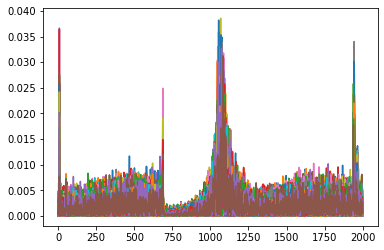

In [15]:
plt.plot(result.transpose())
plt.show()

In [ ]:
np.max(result,0)